# Deep Learning Summer Course - Exercise 3
### Summer 2024 - Thursday 8-8-2024

To solve these exercises, you will use Python3 and the following packages:
- **NumPy**: For various data transformations and generating data.
- **Pandas**: For importing data into a DataFrame similar to how it's done in R.
- **Matplotlib**: For graphing data and data transformations.
- **PyTorch**: For building and training neural networks.
- **Seaborn**: For creating informative and aesthetically appealing statistical graphics in Python.

You are not strictly forced to use these packages, but it is highly recommended.

We will go through your results of this exercise on Friday 9-8-2024, so you are expected to have completed them.

**Question or comments**: Lucas Alexander Damberg Torp Dyssel

### Import the required libraries

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Load the MNIST dataset

In [24]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

### Define the neural network model

In [25]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN()

### Define the loss function and optimizer

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Training and evaluation functions

In [32]:
def train_model(model, criterion, optimizer, num_epochs=5):
    losses = []
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return losses

def evaluate_model(model, is_regularized=False):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            if is_regularized:
                outputs = outputs[0]  # Unpack only if outputs is a tuple
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy: {100 * correct / total}%')



### Train and evaluate base model

Epoch [1/5], Loss: 0.9826
Epoch [2/5], Loss: 0.3732
Epoch [3/5], Loss: 0.3355
Epoch [4/5], Loss: 0.2854
Epoch [5/5], Loss: 0.2529


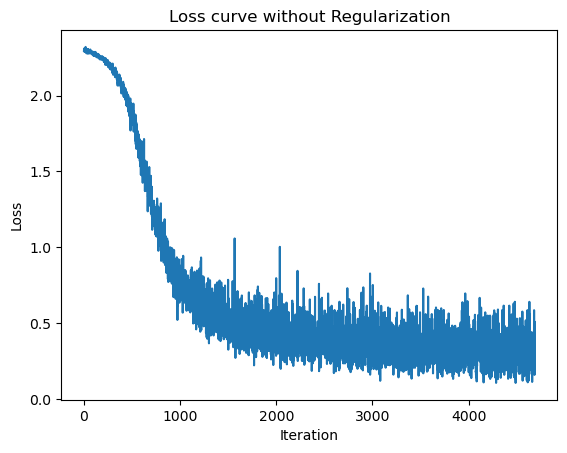

Accuracy: 91.4%


In [28]:
# Train and evaluate the model
losses = train_model(model, criterion, optimizer)
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss curve without Regularization')
plt.show()

evaluate_model(model)

## 1. Regularization

### 1a. Add L1 regularization to the 2nd layer

Epoch [1/5], Loss: 1.2310
Epoch [2/5], Loss: 0.9162
Epoch [3/5], Loss: 0.4757
Epoch [4/5], Loss: 0.6404
Epoch [5/5], Loss: 0.4288


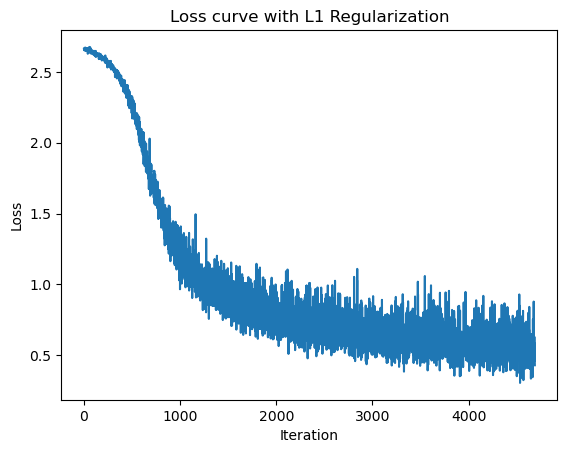

Accuracy: 90.65%


In [29]:
# L1 Regularization section
l1_lambda = 0.001
def l1_regularization(model, l1_lambda):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return l1_lambda * l1_norm

class L1RegularizedNN(SimpleNN):
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        l1_norm = l1_regularization(self.fc2, l1_lambda)
        return x, l1_norm

model = L1RegularizedNN()
optimizer = optim.SGD(model.parameters(), lr=0.01)

losses = []
num_epochs = 5
for epoch in range(num_epochs):
    for images, labels in train_loader:
        outputs, l1_norm = model(images)
        loss = criterion(outputs, labels) + l1_norm
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss curve with L1 Regularization')
plt.show()

evaluate_model(model, is_regularized=True)


### 1b. Add L2 regularization instead on the 2nd layer

Epoch [1/5], Loss: 0.9359
Epoch [2/5], Loss: 0.4810
Epoch [3/5], Loss: 0.3740
Epoch [4/5], Loss: 0.2956
Epoch [5/5], Loss: 0.4189


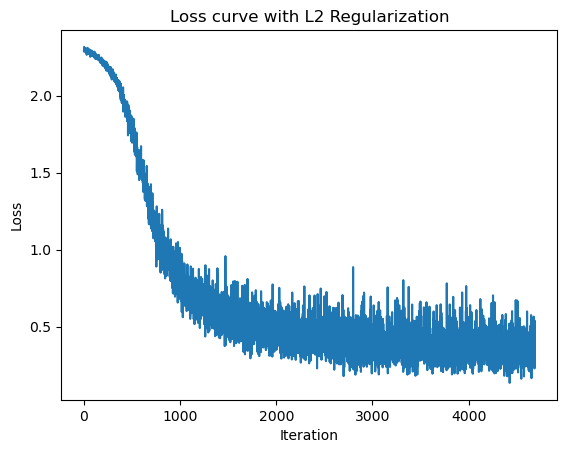

ValueError: too many values to unpack (expected 2)

In [31]:
# Define the neural network model without any regularization
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model, define the loss function and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

# Train and evaluate the model with L2 regularization
losses = train_model(model, criterion, optimizer)
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss curve with L2 Regularization')
plt.show()

evaluate_model(model)


### 1c. Observation on the impact of lambda value

_Hint: Observe the training loss and accuracy when changing the lambda values._

### 1d. Purpose of adding regularization

_Hint: Regularization helps prevent overfitting by adding a penalty for larger weights._

## 2. Dropout

### 2a. Add a dropout layer between the first and second layer

In [ ]:
class DropoutNN(nn.Module):
    def __init__(self):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = DropoutNN()
optimizer = optim.SGD(model.parameters(), lr=0.01)
losses = train_model(model, criterion, optimizer)

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss curve with Dropout')
plt.show()

evaluate_model(model)

### 2b. Purpose of adding dropout

_Hint: Dropout helps to prevent overfitting by randomly setting some neurons to zero during training._

## 3. Layers

### 3a. Experiment with different amounts of layers

_Hint: Add or remove layers and observe the impact on model performance._

In [ ]:
class MoreLayersNN(nn.Module):
    def __init__(self):
        super(MoreLayersNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = MoreLayersNN()
optimizer = optim.SGD(model.parameters(), lr=0.01)
losses = train_model(model, criterion, optimizer)

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss curve with More Layers')
plt.show()

evaluate_model(model)

### 3b. Experiment with different amounts of neurons in each layer

_Hint: Increase or decrease the number of neurons and observe the impact on model performance._

In [ ]:
class MoreNeuronsNN(nn.Module):
    def __init__(self):
        super(MoreNeuronsNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = MoreNeuronsNN()
optimizer = optim.SGD(model.parameters(), lr=0.01)
losses = train_model(model, criterion, optimizer)

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss curve with More Neurons')
plt.show()

evaluate_model(model)

## 4. Momentum

### 4a. Try to add momentum to the SGD optimizer

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
losses = train_model(model, criterion, optimizer)

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss curve with Momentum 0.9')
plt.show()

evaluate_model(model)

### 4b. Test different values of momentum

In [ ]:
momentum_values = [0.5, 0.7, 0.9]
for momentum in momentum_values:
    model = SimpleNN()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=momentum)
    losses = train_model(model, criterion, optimizer)
    
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Loss curve with Momentum {momentum}')
    plt.show()
    evaluate_model(model)

### 4c. What happens if momentum is too high?

_Hint: Observe the training stability and performance when using high momentum values._